# OpenSeeD embedding test
This notebook demonstrates how to obtain text and pixel embeddings using the utilities in the `tools` package.

In [26]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from matplotlib.patches import Patch

In [27]:
import os, sys
# this cell is required to make the next relative import statement possible
NB_DIR = os.getcwd() # /home/jovyan/teaching_material/msc/MSc-Thesis
OPENSEED_ROOT = os.path.abspath(os.path.join(NB_DIR, '..', 'OpenSeeD'))

TOOLS_DIR = os.path.join(OPENSEED_ROOT, 'tools')
for p in (TOOLS_DIR, OPENSEED_ROOT):
    if p not in sys.path:
        sys.path.insert(0, p)

In [28]:
from openseed_dump_text import openseed_text
from openseed_dump_pixels import load_model, pixel_features

In [29]:
segmentation_classes = ["big flat counter", "sofa", "floor", "chair", "wash basin", "picture", "other"]
emb = openseed_text(segmentation_classes)
print('text embedding shape:', emb.shape)

text embedding shape: (7, 512)


In [30]:
img_path = '/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/5LpN3gDmAk7_370.png'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_model('configs/openseed/openseed_swinl_lang_decouple.yaml', 'weights/openseed_swinl_pano_sota.pt', device)
feats = pixel_features(model, img_path)
print('pixel features shape:', feats.shape)  # should be (512,H,W)

self.task_switch  {'coco': True, 'o365': True}


*UNLOADED* criterion_coco.empty_weight, Model Shape: torch.Size([134])
*UNLOADED* criterion_o365.empty_weight, Model Shape: torch.Size([366])
$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([134])


pixel features shape: (512, 720, 1080)


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Patch

def visualize_all_segmentation(img_path, feats, label_embs, label_names, alpha=0.5):
    """
    - feats:  (C, H, W) array or torch tensor of per-pixel features
    - label_embs: (K, C) array of text embeddings for your K classes
    - label_names: list of K strings
    - alpha: overlay transparency
    """
    # 1) to NumPy & shape
    if hasattr(feats, "cpu"):
        arr = feats.cpu().numpy()
    else:
        arr = feats
    C, H, W = arr.shape
    K, _ = label_embs.shape

    # 2) compute score map: (K, H, W)
    flat = arr.reshape(C, -1)              # (C, N)
    scores = label_embs @ flat             # (K, N)
    scores = scores.reshape(K, H, W)

    # 3) assign each pixel to highest-scoring class
    seg = np.argmax(scores, axis=0)        # (H, W) with values in 0…K-1

    # 4) load image
    img = np.array(Image.open(img_path).convert("RGB"), dtype=float) / 255.0

    # 5) pick K distinct colors
    cmap = plt.get_cmap("tab20", K)
    colors = cmap(range(K))[:, :3]         # shape (K,3)

    # 6) build color mask & overlay
    color_mask = colors[seg]               # (H, W, 3)
    overlay = img * (1 - alpha) + color_mask * alpha

    # 7) plot
    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.axis("off")

    # 8) legend
    patches = [Patch(color=colors[i], label=label_names[i])
               for i in range(K)]
    plt.legend(handles=patches,
               bbox_to_anchor=(1.05, 1),
               loc="upper left",
               borderaxespad=0.)
    plt.tight_layout()
    plt.show()

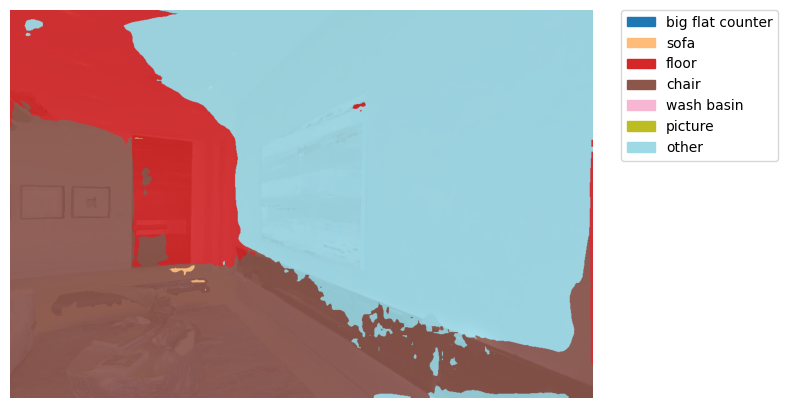

In [32]:
visualize_all_segmentation(img_path, feats, emb, segmentation_classes, alpha=0.9)